In [62]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
from flopy.utils.triangle import Triangle as Triangle
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob

sys.path.insert(1, '../test_premier_model/')
# hand made functions
from Rouss1 import *
from Rouss2 import *

In [63]:
model_dir = "working"
model_name = "Refining"
exe_name= "../../exe/mf6"

In [64]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../data/txt_couches_nouv/s1_mnt.txt"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

In [65]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = 660e3,615e4,710e3,620e4

Lx = x1-x0
Ly = y1-y0
nlay = 1
delc = delr = 500
ncol = int(Lx/delr)
nrow = int(Ly/delc)
top = 1
botm = 0


In [66]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='refine_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)

# create tdis package
tdis_rc = [(1, 1, 1)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname="model_name",
                           model_nam_file='{}.nam'.format(model_name))

dis = fp.mf6.ModflowGwfdis(gwf,nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0)

In [67]:
g = Gridgen(dis, model_ws=model_dir,exe_name="../../exe/Gridgen.exe")

In [68]:
#add refinement around a polygon
# g.add_refinement_features("shp/limiteModeleRoussillon_poly","polygon",1,range(nlay))

#add river
g.add_refinement_features("../../../data/Fleuves/Agly_ludo","line",2,range(nlay))

In [69]:
g.build()

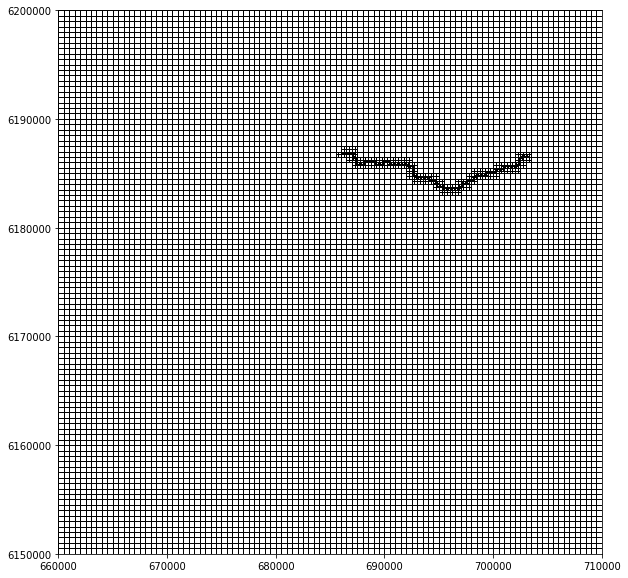

In [70]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwf)
g.plot()

In [71]:
def gridgen2grid(g):
    gridprops = g.get_gridprops_disv()
    ncpl = gridprops['ncpl']
    top = gridprops['top']
    botm = gridprops['botm']
    nvert = gridprops['nvert']
    vertices = gridprops['vertices']
    cell2d = gridprops['cell2d']
    
    grid = fp.discretization.VertexGrid(vertices = vertices,cell2d=cell2d)
    return grid

In [72]:
grid = gridgen2grid(g)

In [79]:
ls1 = LineString([(680e3,618.5e4),(700e3,618.5e4)])
ix = GridIntersect(grid)
ix.intersect_linestring(ls1)

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 692750 6185000 at 692750 6185000


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x000002A9FDF88208>